In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from torch import nn

#数据预处理
data = pd.read_csv('example_wp_log_peyton_manning.csv',usecols=[1])
data = data.dropna() #丢弃空值
dataset = data.values
dataset = dataset.astype('float32')

max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x/scalar, dataset)) #将数据归一化到0~1之间

#划分数据集
#通过前面几条的数据来预测下一条的数据，look_back设置具体的把前面几条的数据作为预测的输入data_X，而输出就是下一条data_Y
def create_dataset(dataset,look_back=2): # 每个的滑动窗口设置为2
    dataX, dataY=[], []
    for i in range(len(dataset)-look_back):
        a=dataset[i:(i+look_back)]
        dataX.append(a)    # 记录窗口的值
        dataY.append(dataset[i+look_back]) # 记录除了前面两个以外的所有值作为正确的标签
    return np.array(dataX), np.array(dataY)
#创建好输入与输出 data_Y作为正确的预测值
data_X, data_Y = create_dataset(dataset)

#划分训练集和测试集，70%作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X)-train_size

train_X = data_X[:train_size]
train_Y = data_Y[:train_size]

test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

#最后，我们需要将数据改变一下形状，因为 RNN 读入的数据维度是 (seq, batch, feature)，所以要重新改变一下数据的维度，这里只有一个序列，所以 batch 是 1，而输入的 feature 就是我们希望依据的几天，这里我们定的是两个天，所以 feature 就是 2.

train_X = train_X.reshape(-1,1,2)
train_Y = train_Y.reshape(-1,1,1)
test_X = test_X.reshape(-1,1,2)

# 转化成torch 的张量
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [2]:
#lstm 网络
class lstm_reg(nn.Module):#括号中的是python的类继承语法，父类是nn.Module类 不是参数的意思
    def __init__(self,input_size,hidden_size, output_size=1,num_layers=2): # 构造函数
        #inpu_size 是输入的样本的特征维度， hidden_size 是LSTM层的神经元个数，
        #output_size是输出的特征维度
        super(lstm_reg,self).__init__()# super用于多层继承使用，必须要有的操作
 
        self.rnn = nn.LSTM(input_size,hidden_size,num_layers)# 两层LSTM网络，
        self.reg = nn.Linear(hidden_size,output_size)#把上一层总共hidden_size个的神经元的输出向量作为输入向量，然后回归到output_size维度的输出向量中
 
    def forward(self,x): #x是输入的数据
        x, _ = self.rnn(x)# 单个下划线表示不在意的变量，这里是LSTM网络输出的两个隐藏层状态
        s,b,h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s,b,-1)#使用-1表示第三个维度自动根据原来的shape 和已经定了的s,b来确定
        return x
#我使用了GPU加速，如果不用的话需要把.cuda()给注释掉    
net = lstm_reg(2,4)
net = net.cuda()
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)    

In [3]:
for e in range(10000):
# 新版本中可以不使用Variable了    
#     var_x = Variable(train_x).cuda() 
#     var_y = Variable(train_y).cuda()

#将tensor放在GPU上面进行运算
    var_x = train_x.cuda()
    var_y = train_y.cuda()
 
    out = net(var_x)
    loss = criterion(out, var_y)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e+1)%100 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.item()))
#存储训练好的模型参数        
torch.save(net.state_dict(), 'example_wp_log.net_params.pkl')

Epoch: 100, Loss:0.01162
Epoch: 200, Loss:0.01150
Epoch: 300, Loss:0.01135


KeyboardInterrupt: 

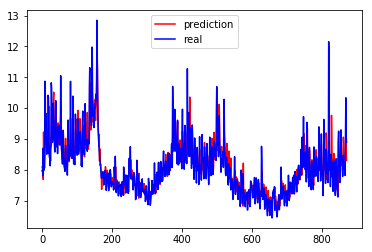

0.19564899538002084


In [11]:
net.load_state_dict(torch.load('example_wp_log.net_params.pkl')) 
var_data = torch.from_numpy(test_X).cuda()#net在GPU上面，所以输入的测试集合也要转入到GPU上面
pred_test = net(var_data) # 测试集的预测结果
pred_test = pred_test.cpu().view(-1).data.numpy()#先转移到cpu上才能转换为numpy

#乘以原来归一化的刻度放缩回到原来的值域 
origin_test_Y = test_Y*scalar
origin_pred_test = pred_test*scalar

#画图
plt.plot(origin_pred_test, 'r', label='prediction')
plt.plot(origin_test_Y, 'b', label='real')
plt.legend(loc='best')
plt.show()

#计算MSE
#loss = criterion(out, var_y)？
true_data = origin_test_Y
true_data = np.array(true_data)
true_data = np.squeeze(true_data)  # 从二维变成一维
MSE = true_data - origin_pred_test
MSE = MSE*MSE
MSE_loss = sum(MSE)/len(MSE)
print(MSE_loss)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\BraveY\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



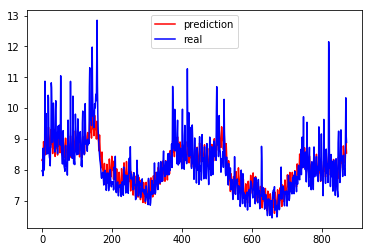

0.25229994660830146


In [13]:
import pandas as pd
from fbprophet import Prophet
df = pd.read_csv('example_wp_log_peyton_manning.csv')

#Prophet使用
m = Prophet()
m.fit(df)
#需要预测时间段为整个365天，也就是下一年的整个天数
future = m.make_future_dataframe(periods=365)
#开始预测
forecast = m.predict(future)
#预测的结果保存在yhat_upper列中
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#画图
plt.plot(fb_pre, 'r', label='prediction')
plt.plot(origin_test_Y, 'b', label='real')
plt.legend(loc='best')
plt.show()
#计算MSE
fb_pre = np.array(forecast['yhat'].iloc[2034:2905])#2034到2905是前面30%的测试集所对应的数据范围
MSE = true_data - fb_pre
MSE = MSE*MSE
MSE_loss = sum(MSE)/len(MSE)
print(MSE_loss)